In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%env MYPATH=../../../../storage/feathernox/

env: MYPATH=../../../../storage/feathernox/


In [3]:
MYPATH = '../../../../storage/feathernox/'

In [4]:
BATCH_SIZE = 32

In [5]:
! ls $MYPATH

aux_files		 cifar-10-batches-py	 omniglot	      SVHN
cifar-100-python	 cifar-10-python.tar.gz  stl10_binary
cifar-100-python.tar.gz  MNIST			 stl10_binary.tar.gz


In [67]:
import lib.data_util as data_util
import lib.nn_util as nn_util
from lib.callback import PlotCallback
from tqdm import tqdm_notebook as tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

MAKE_SPLITS = False

def create_splits():
    mnist_train, mnist_val, mnist_test = data_util.create_mnist_train_val_test_split(make_new=True)
    for class_size in tqdm(data_util.MNIST_SIZES[::-1]):
        if class_size < 100:
            n = 3
        else:
            n = 1
        for (mnist_labeled, mnist_unlabeled) in tqdm(
            data_util.create_mnist_labeled_unlabeled_splits(mnist_train, n=n, class_size=class_size, make_new=True)):
            continue
 
if MAKE_SPLITS:
    create_splits()

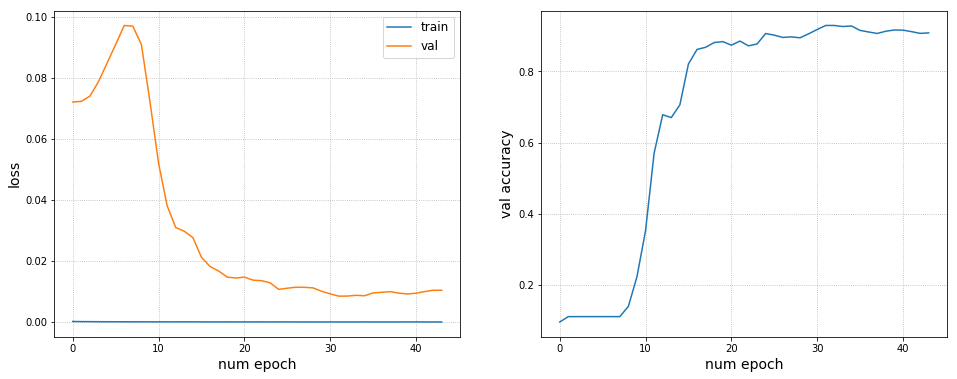

In [45]:
mnist_train, mnist_val, mnist_test = data_util.create_mnist_train_val_test_split(make_new=False)
mnist_val.transform = transforms.ToTensor()
mnist_test.transform = transforms.ToTensor()

tags = []
for class_size in tqdm(data_util.MNIST_SIZES[::-1]):
    if class_size < 100:
        n = 3
    else:
        n = 1
    for idx_split, (mnist_labeled, mnist_unlabeled) in tqdm(
            enumerate(data_util.create_mnist_labeled_unlabeled_splits(
                mnist_train, n=n, class_size=class_size, make_new=False))):
        for augmented in tqdm([True, False]):
            if augmented:
                transform = transforms.ToTensor()
            else:
                transform = data_util.MNIST_AUGMENTATION
                
            mnist_labeled.transform = transform
            models = nn_util.get_mnist_models()
            for idx_model, model in tqdm(enumerate(models)):
                tag = 'size_{0}_split_{1}_augmented_{2}_model_{3}'.format(
                    class_size, idx_split, int(augmented), idx_model)
                model.cuda()
                callback = PlotCallback(mnist_train,
                                        path_model='aux_files/best_model_{}.pkl'.format(tag),
                                        path_plot='aux_files/graph_{}.png'.format(tag),
                                        path_callback='aux_files/callback_{}.pkl'.format(tag))
                opt = torch.optim.Adam(model.parameters())
                nn_util.train_neural_network(mnist_labeled, mnist_val, model, opt, callback, batch_size=BATCH_SIZE)

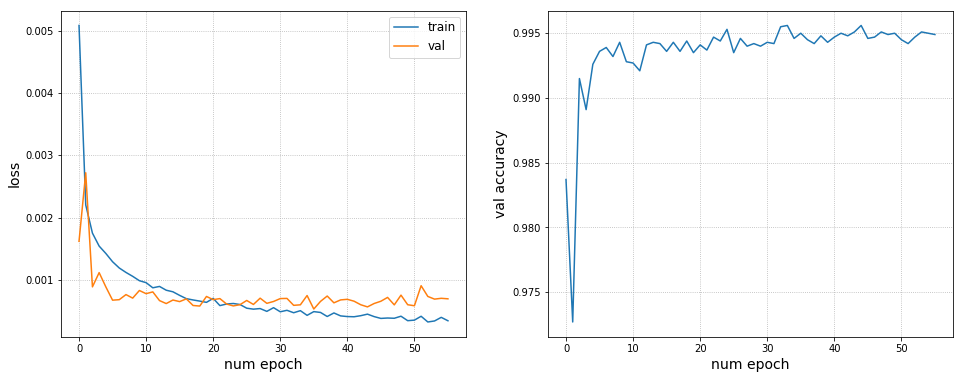

In [17]:
for augmented in tqdm([True, False]):
    if augmented:
        transform = transforms.ToTensor()
    else:
        transform = data_util.MNIST_AUGMENTATION
        
    mnist_train.transform = transform
    models = nn_util.get_mnist_models()
    for idx_model, model in tqdm(enumerate(models)):
        tag = 'full_augmented_{0}_model_{1}'.format(int(augmented), idx_model)
        model.cuda()
        callback = PlotCallback(mnist_train,
                                path_model='aux_files/best_model_{}.pkl'.format(tag),
                                path_plot='aux_files/graph_{}.png'.format(tag),
                                path_callback='aux_files/callback_{}.pkl'.format(tag))
        opt = torch.optim.Adam(model.parameters())
        nn_util.train_neural_network(mnist_train, mnist_val, model, opt, callback, batch_size=BATCH_SIZE)

In [5]:
mnist_train, mnist_val, mnist_test = data_util.create_mnist_train_val_test_split(make_new=False)
mnist_val.transform = transforms.ToTensor()
mnist_test.transform = transforms.ToTensor()
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)

accuracies = {}
for class_size in tqdm(data_util.MNIST_SIZES[::-1]):
    if class_size < 100:
        n = 3
    else:
        n = 1
    for idx_split, (mnist_labeled, mnist_unlabeled) in enumerate(data_util.create_mnist_labeled_unlabeled_splits(
                mnist_train, n=n, class_size=class_size, make_new=False)):
        for augmented in [True, False]:
            models = nn_util.get_mnist_models()
            for idx_model, model in enumerate(models):
                tag = 'size_{0}_split_{1}_augmented_{2}_model_{3}'.format(
                    class_size, idx_split, int(augmented), idx_model)
                model.cuda()
                model.load_state_dict(
                    torch.load('aux_files/best_model_{}.pkl'.format(tag)))
                accuracies[tag] = nn_util.evaluate_accuracy(model, test_loader)[1]
                
for augmented in tqdm([True, False]):
    if augmented:
        transform = transforms.ToTensor()
    else:
        transform = data_util.MNIST_AUGMENTATION
    
    models = nn_util.get_mnist_models()
    for idx_model, model in tqdm(enumerate(models)):
        tag = 'full_augmented_{0}_model_{1}'.format(int(augmented), idx_model)
        model.cuda()
        model.load_state_dict(torch.load('aux_files/best_model_{}.pkl'.format(tag)))
        accuracies[tag] = nn_util.evaluate_accuracy(model, test_loader)[1]

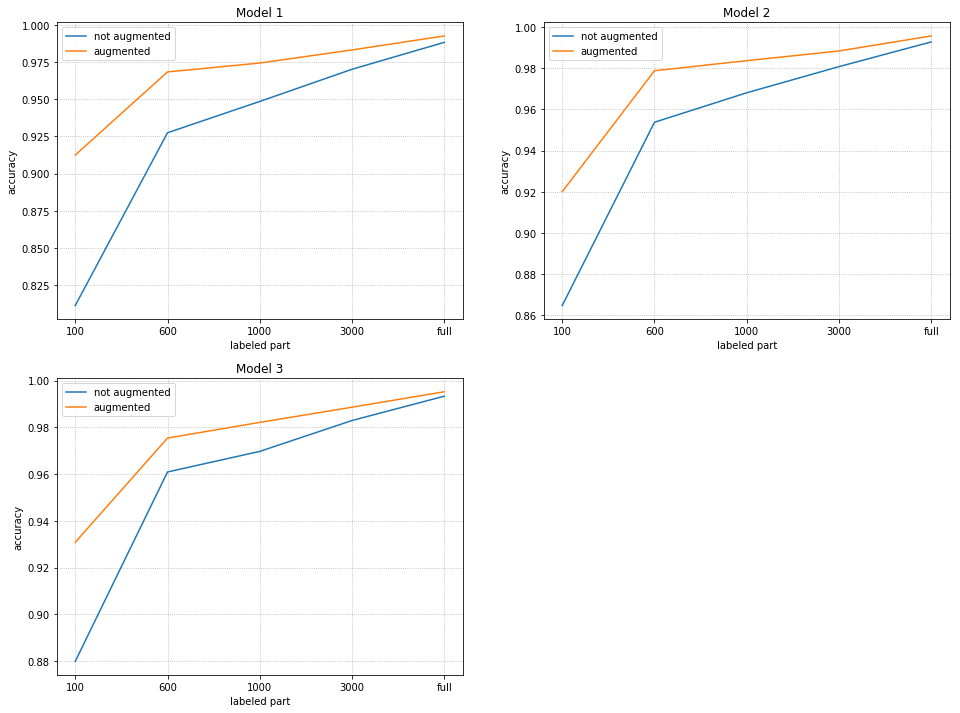

In [31]:
plt.figure(figsize=(16, 12))
for idx_model in range(len(models)):
    plt.subplot(2, 2, idx_model + 1)
    for augmented in [True, False]:
        accs = []
        for class_size in data_util.MNIST_SIZES:
            acc = 0
            if class_size < 100:
                n = 3
            else:
                n = 1
            for idx_split in range(n):
                tag = 'size_{0}_split_{1}_augmented_{2}_model_{3}'.format(
                    class_size, idx_split, int(augmented), idx_model)
                acc += accuracies[tag]
            acc /= n
            accs.append(acc)
        tag = 'full_augmented_{0}_model_{1}'.format(int(augmented), idx_model)
        accs.append(accuracies[tag])
        plt.title('Model {}'.format(idx_model + 1))
        plt.plot(accs, label='not augmented' if augmented else 'augmented')
        plt.grid(ls=":")
        plt.xticks(np.arange(5), [10 * size for size in data_util.MNIST_SIZES] + ['full'])
        plt.xlabel('labeled part')
        plt.ylabel('accuracy')
        plt.legend()

In [40]:

with open('aux_files/accuracies.pkl', 'wb') as f:
    pkl.dump(accuracies, f)

In [38]:
mnist_train.transform = transforms.ToTensor()

In [44]:
mnist_test.transform

ToTensor()

In [ ]:
mnist_train, mnist_val, mnist_test = data_util.create_mnist_train_val_test_split(make_new=False)
mnist_val.transform = transforms.ToTensor()
mnist_test.transform = transforms.ToTensor()
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)

import lib.embeddings_util as embeddings_util
import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

for class_size in tqdm(data_util.MNIST_SIZES[::-1]):
    if class_size < 100:
        n = 3
    else:
        n = 1
    for idx_split, (mnist_labeled, mnist_unlabeled) in enumerate(data_util.create_mnist_labeled_unlabeled_splits(
                mnist_train, n=n, class_size=class_size, make_new=False)):
        mnist_labeled.transform = transforms.ToTensor()
        mnist_unlabeled.transform = transforms.ToTensor()
        for augmented in [True, False]:
            models = nn_util.get_mnist_models()
            for idx_model, model in enumerate(models):
                tag = 'size_{0}_split_{1}_augmented_{2}_model_{3}'.format(
                    class_size, idx_split, int(augmented), idx_model)
                model.cuda()
                model.train(False)
                model.load_state_dict(
                    torch.load('aux_files/best_model_{}.pkl'.format(tag)))
                model.logits = Identity()
                model.train(False)
                results = embeddings_util.extend_sample(
                    model, mnist_labeled, mnist_unlabeled, mnist_val, mnist_test, batch_size=BATCH_SIZE)
                with open(MYPATH + 'aux_files/embeds_{}.pkl'.format(tag), 'wb') as f:
                    pkl.dump(results, f)

In [38]:
train_X.shape

(100, 256)

In [58]:
from sklearn.neighbors import KDTree
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


def compute_knn(results):
    result_neighbors = {}
    N_NEIGHBORS = [1]
    test_X = results['test']['X']
    test_y = results['test']['y']
    train_X = results['extended'][2]['X'][:class_size*10]
    train_y = results['extended'][2]['y'][:class_size*10]
    for n in N_NEIGHBORS:
        result_neighbors[n] = {}
        kNN = KNeighborsClassifier(n_neighbors=n)
        kNN.fit(train_X, train_y)
        result_neighbors[n][1] = accuracy_score(kNN.predict(test_X), test_y)
        for key in results['extended']:
            kNN = KNeighborsClassifier(n_neighbors=n)
            kNN.fit(results['extended'][key]['X'], results['extended'][key]['y'])
            result_neighbors[n][key] = accuracy_score(kNN.predict(test_X), test_y)
    return result_neighbors[1]

In [54]:
result_neighbors

{1: {'full': 0.9314, 2: 0.9345, 4: 0.9351, 8: 0.9377, 16: 0.9391},
 2: {'full': 0.9303, 2: 0.9355, 4: 0.937, 8: 0.9386, 16: 0.941},
 3: {'full': 0.9309, 2: 0.9332, 4: 0.9371, 8: 0.9379, 16: 0.9404},
 4: {'full': 0.9344, 2: 0.9354, 4: 0.9358, 8: 0.9391, 16: 0.9415},
 5: {'full': 0.9335, 2: 0.9335, 4: 0.937, 8: 0.9379, 16: 0.9404}}

In [ ]:
graph_neighbors_data = {}

for class_size in tqdm(data_util.MNIST_SIZES[::-1]):
    if class_size < 100:
        n = 3
    else:
        n = 1
    for idx_split in tqdm(range(n)):
        for augmented in tqdm([True, False]):
            for idx_model, model in tqdm(enumerate(models)):
                tag = 'size_{0}_split_{1}_augmented_{2}_model_{3}'.format(
                    class_size, idx_split, int(augmented), idx_model)
                with open(MYPATH + 'aux_files/embeds_{}.pkl'.format(tag), 'rb') as f:
                    results = pkl.load(f)
                result_neighbors = compute_knn(results)
                graph_neighbors_data[tag] = result_neighbors
                
with open('aux_files/graph_neighbors_data.pkl', 'wb') as f:
    pkl.dump(graph_neighbors_data, f)


In [64]:
for tag in graph_neighbors_data:
    graph_neighbors_data[tag][1] = graph_neighbors_data[tag]['full']
    graph_neighbors_data[tag].pop('full')

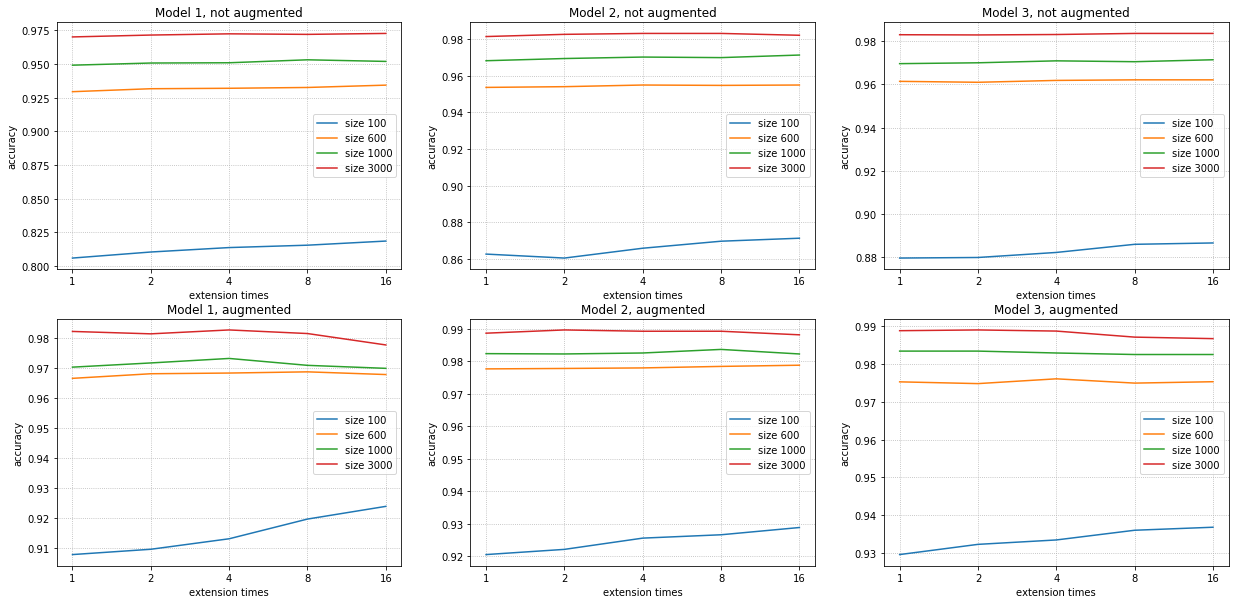

In [76]:
EXTENSION_TIMES = [1, 2, 4, 8, 16]

plt.figure(figsize=(21, 10))
for augmented in [True, False]:
    for idx_model in range(3):
        plt.subplot(2, 3, (1 - augmented) * 3 + idx_model + 1)
        for class_size in data_util.MNIST_SIZES:
            accs = [0 for _ in range(len(EXTENSION_TIMES))]
            if class_size < 100:
                n = 3
            else:
                n = 1
            for idx_split in range(n):
                tag = 'size_{0}_split_{1}_augmented_{2}_model_{3}'.format(
                            class_size, idx_split, int(augmented), idx_model)
                for i, ext in enumerate(EXTENSION_TIMES):
                    accs[i] += graph_neighbors_data[tag][ext]
            accs = [acc / n for acc in accs]
            plt.plot(accs, label='size {}'.format(class_size * 10))
            plt.grid(ls=":")
        plt.xticks(np.arange(5), EXTENSION_TIMES)
        plt.title('Model {0}, {1}'.format(idx_model + 1, 'not augmented' if augmented else 'augmented'))
        plt.xlabel('extension times')
        plt.ylabel('accuracy')
        plt.legend()

In [18]:
test_X

{'X': array([[ 0.95877856, -0.22386654,  0.01077515, ...,  0.45127442,
          0.7498838 , -0.4724098 ],
        [ 0.03307178, -0.22386654,  0.1377989 , ..., -0.7360608 ,
         -0.04436092, -0.4724098 ],
        [-0.06456783,  2.5830703 , -0.05554238, ...,  1.1103048 ,
         -0.04436092, -0.4724098 ],
        ...,
        [-0.06456783, -0.22386654,  0.15596287, ...,  2.5526595 ,
         -0.04436092,  0.2138396 ],
        [-0.06456783, -0.22386654,  0.10398565, ...,  0.24725051,
         -0.04436092, -0.4724098 ],
        [-0.06456783, -0.22386654,  0.02979955, ...,  0.5126201 ,
         -0.04436092, -0.4724098 ]], dtype=float32),
 'y': array([7, 2, 1, ..., 4, 5, 6])}

In [15]:
help(KDTree)

Help on class KDTree in module sklearn.neighbors.kd_tree:

class KDTree(BinaryTree)
 |  KDTree for fast generalized N-point problems
 |  
 |  KDTree(X, leaf_size=40, metric='minkowski', \**kwargs)
 |  
 |  Parameters
 |  ----------
 |  X : array-like, shape = [n_samples, n_features]
 |      n_samples is the number of points in the data set, and
 |      n_features is the dimension of the parameter space.
 |      Note: if X is a C-contiguous array of doubles then data will
 |      not be copied. Otherwise, an internal copy will be made.
 |  
 |  leaf_size : positive integer (default = 40)
 |      Number of points at which to switch to brute-force. Changing
 |      leaf_size will not affect the results of a query, but can
 |      significantly impact the speed of a query and the memory required
 |      to store the constructed tree.  The amount of memory needed to
 |      store the tree scales as approximately n_samples / leaf_size.
 |      For a specified ``leaf_size``, a leaf node is gu

In [11]:
! ls '../../../../storage/feathernox/aux_files'

In [ ]:

for class_size in tqdm(data_util.MNIST_SIZES[::-1]):
    if class_size < 100:
        n = 3
    else:
        n = 1
    for idx_split, (mnist_labeled, mnist_unlabeled) in enumerate(data_util.create_mnist_labeled_unlabeled_splits(
                mnist_train, n=n, class_size=class_size, make_new=False)):
        mnist_labeled.transform = transforms.ToTensor()
        mnist_unlabeled.transform = transforms.ToTensor()
        for augmented in [True, False]:
            models = nn_util.get_mnist_models()
            for idx_model, model in enumerate(models):
                tag = 'size_{0}_split_{1}_augmented_{2}_model_{3}'.format(
                    class_size, idx_split, int(augmented), idx_model)
                model.cuda()
                model.load_state_dict(
                    torch.load('aux_files/best_model_{}.pkl'.format(tag)))
                results = embeddings_util.extend_sample(
                    model, mnist_labeled, mnist_unlabeled, mnist_val, mnist_test, batch_size=BATCH_SIZE)
                with open('aux_files/embeds_{}.pkl'.format(tag), 'rb') as f:
                    pkl.dump(results, f)

In [54]:
with open('aux_files/embeds_{}.pkl'.format(tag), 'rb') as f:
    print(pkl.load(f)['extended'][2]['X'].shape)

(200, 10)


NameError: name 'mnist_test' is not defined

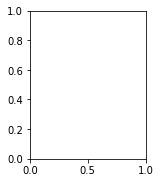

In [6]:
import PIL
import matplotlib.pyplot as plt
import numpy as np
from lib.data_util import MNIST_AUGMENTATION
    

idx = 3

plt.figure(figsize=(12, 6))

plt.subplot(2, 5, 1)
plt.imshow(np.array(mnist_test[idx][0]), cmap='gray')
plt.xlabel('original', fontsize=12)

for i in range(9):
    plt.subplot(2, 5, i + 2)
    plt.imshow(MNIST_AUGMENTATION(mnist_test[idx][0]).cpu().data.numpy()[0], cmap='gray')
    plt.xlabel('transformation {0}'.format(i + 1), fontsize=12)
    
plt.show()

In [ ]:

                callback = PlotCallback(mnist_train,
                                        path_model='aux_files/best_model_{}.pkl'.format(tag),
                                        path_plot='aux_files/graph_{}.png'.format(tag),
                                        path_callback='aux_files/callback_{}.pkl'.format(tag))
                opt = torch.optim.Adam(model.parameters())
                nn_util.train_neural_network(mnist_labeled, mnist_val, model, opt, callback)

In [ ]:
for class_size in tqdm(data_util.MNIST_SIZES[::-1]):
    if class_size < 100:
        n = 3
    else:
        n = 1

In [15]:
accuracies

{'size_300_split_0_augmented_1_model_0': 0.9701,
 'size_300_split_0_augmented_1_model_1': 0.9808,
 'size_300_split_0_augmented_1_model_2': 0.9829,
 'size_300_split_0_augmented_0_model_0': 0.9831,
 'size_300_split_0_augmented_0_model_1': 0.9884,
 'size_300_split_0_augmented_0_model_2': 0.9886,
 'size_100_split_0_augmented_1_model_0': 0.9485,
 'size_100_split_0_augmented_1_model_1': 0.9681,
 'size_100_split_0_augmented_1_model_2': 0.9697,
 'size_100_split_0_augmented_0_model_0': 0.9743,
 'size_100_split_0_augmented_0_model_1': 0.9837,
 'size_100_split_0_augmented_0_model_2': 0.9821,
 'size_60_split_0_augmented_1_model_0': 0.9283,
 'size_60_split_0_augmented_1_model_1': 0.9575,
 'size_60_split_0_augmented_1_model_2': 0.9608,
 'size_60_split_0_augmented_0_model_0': 0.9702,
 'size_60_split_0_augmented_0_model_1': 0.98,
 'size_60_split_0_augmented_0_model_2': 0.9715,
 'size_60_split_1_augmented_1_model_0': 0.9229,
 'size_60_split_1_augmented_1_model_1': 0.9486,
 'size_60_split_1_augmented_1_

In [9]:
from torchvision.transforms import ToTensor

labeled, unlabeled = train_splits[0]
batch_size = 32

labeled.transform = ToTensor()
mnist_val.transform = ToTensor()

In [10]:
from torch.utils.data import DataLoader
from copy import deepcopy


unlabeled.transform = ToTensor()
unlabeled_loader = DataLoader(unlabeled, batch_size=batch_size, shuffle=False)

device = torch.device('cpu')
model = deepcopy(models[2].cpu())
model.load_state_dict(torch.load('aux_files/best_model.pkl', map_location=device))
model.logits = Identity()


Sequential(
  (conv1): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu_conv1): ReLU()
  (bn_conv1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu_conv2): ReLU()
  (bn_conv2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu_conv3): ReLU()
  (bn_conv3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=1024, out_features=256, bias=True)
  (relu_linear1): ReLU()
  (bn_linear1): BatchNorm1d(256, e

In [11]:
labeled.transform = ToTensor()
labeled, unlabeled = train_splits[0]

In [12]:
batch_size = 32

array([7, 2, 1, ..., 4, 5, 6])

In [8]:
from torch.utils.data import DataLoader
batch_size=32
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [15]:
model.cuda()

Sequential(
  (conv1): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu_conv1): ReLU()
  (bn_conv1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu_conv2): ReLU()
  (bn_conv2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu_conv3): ReLU()
  (bn_conv3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=1024, out_features=256, bias=True)
  (relu_linear1): ReLU()
  (bn_linear1): BatchNorm1d(256, e

In [16]:
from lib.embeddings_util import extend_sample

In [19]:
mnist_test.transform = ToTensor()
res = extend_sample(model, labeled, unlabeled, mnist_val, mnist_test, batch_size=32)

In [20]:
res

{'extended': {2: {'X': array([[ 4.08787191e-01,  1.33146401e-04,  1.30547583e-01, ...,
           -7.84122720e-02, -5.50688446e-01, -1.29487038e-01],
          [ 6.20392799e-01,  1.33146401e-04,  1.47629127e-01, ...,
           -9.91608575e-02, -1.91949308e-01, -1.29487038e-01],
          [ 2.71425098e-01,  1.33146401e-04,  8.38601515e-02, ...,
           -9.86678675e-02, -5.50688446e-01, -1.29487038e-01],
          ...,
          [ 1.88176960e-01,  1.33146401e-04,  1.26964822e-01, ...,
            1.71928853e-02, -5.50688446e-01,  3.03522572e-02],
          [-2.14364156e-01,  1.33146401e-04, -9.18602198e-02, ...,
            1.36728529e-02, -5.50688446e-01, -5.17074056e-02],
          [-2.08209790e-02,  1.33146401e-04,  1.43382043e-01, ...,
           -8.00832510e-02, -4.88221198e-01,  8.77552629e-02]]),
   'y': array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7,
          7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
          3, 3, 3, 3, 3, 3

In [20]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

    






In [84]:
extended_indices

array([[ 2889,  2075,  1299, ...,   638,  3269,  2569],
       [ 2211,  1078,  2730, ...,  1623,  1686,  3642],
       [  952,  4396,  4412, ...,  1708,  2861,   275],
       ...,
       [46062, 48458, 45228, ..., 48597, 49281, 49021],
       [48314, 49748, 46095, ..., 45648, 46627, 47311],
       [48282, 47762, 47212, ..., 45231, 46139, 49228]])

In [79]:
from sklearn.metrics import accuracy_score

for k_neighbors in K_NEIGHBORS:
    extended_X, extended_y = samples[k_neighbors + 1]['X'],  samples[k_neighbors + 1]['y']
    n_train, n_val = extended_X.shape[0], len(mnist_val.get_targets())
    spl = PredefinedSplit(np.hstack([np.zeros(n_train), -np.ones(n_val)]))
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid={'n_neighbors': [1, 2, 5, 10, 20]}, n_jobs=5,
                               cv=spl, refit=True)
    grid_search.fit(np.vstack([extended_X, val_X]),
                    np.hstack([extended_y, mnist_val.get_targets()]))
    print(grid_search.best_params_,
          grid_search.best_score_)
    print(accuracy_score(grid_search.best_estimator_.predict(test_X),
                         mnist_test.targets.cpu().data.numpy()))

{'n_neighbors': 5} 1.0
0.9487
{'n_neighbors': 10} 1.0
0.9485
{'n_neighbors': 10} 1.0
0.9485
{'n_neighbors': 10} 0.999375
0.9487


In [71]:
mnist_test.transform = ToTensor()

In [80]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../../../../storage/feathernox/
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

array([[-3.6565834e-01,  1.3314640e-04, -2.6238230e-01, ...,
         1.3590029e-01, -5.5068845e-01, -1.2948704e-01],
       [-2.9156980e-01,  1.3314640e-04,  9.1379277e-02, ...,
        -6.2830143e-02, -5.5068845e-01,  1.1703718e-01],
       [-4.5778040e-02,  1.3314640e-04,  1.6746742e-01, ...,
         9.9002659e-02,  9.8769367e-01, -1.2948704e-01],
       ...,
       [ 2.0700948e-01,  1.3314640e-04,  1.5243240e-01, ...,
         2.5525210e-02,  8.8693082e-01, -4.0049389e-02],
       [ 3.0466303e-01,  1.3314640e-04, -2.7875409e-03, ...,
        -5.3854212e-02, -5.5068845e-01, -1.2948704e-01],
       [-1.2026996e-01,  1.3314640e-04, -3.5073355e-02, ...,
        -1.2792122e-01, -5.5068845e-01,  3.3219832e-01]], dtype=float32)

In [47]:
n_val

10000

In [83]:
test_X

array([[-3.6565834e-01,  1.3314640e-04, -2.6238230e-01, ...,
         1.3590029e-01, -5.5068845e-01, -1.2948704e-01],
       [-2.9156980e-01,  1.3314640e-04,  9.1379277e-02, ...,
        -6.2830143e-02, -5.5068845e-01,  1.1703718e-01],
       [-4.5778040e-02,  1.3314640e-04,  1.6746742e-01, ...,
         9.9002659e-02,  9.8769367e-01, -1.2948704e-01],
       ...,
       [ 2.0700948e-01,  1.3314640e-04,  1.5243240e-01, ...,
         2.5525210e-02,  8.8693082e-01, -4.0049389e-02],
       [ 3.0466303e-01,  1.3314640e-04, -2.7875409e-03, ...,
        -5.3854212e-02, -5.5068845e-01, -1.2948704e-01],
       [-1.2026996e-01,  1.3314640e-04, -3.5073355e-02, ...,
        -1.2792122e-01, -5.5068845e-01,  3.3219832e-01]], dtype=float32)

In [62]:
estimators = []

GridSearchCV(cv=PredefinedSplit(test_fold=array([ 0,  0, ..., -1, -1])),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=5,
             param_grid={'n_neighbors': [1, 2, 5, 7, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [61]:
def estimatorsrur(estimator, ):
    

In [63]:
grid_search.best_params_ 

{'n_neighbors': 10}

In [21]:
samples

{2: {'X': array([[ 4.08787191e-01,  1.33146401e-04,  1.30547583e-01, ...,
          -7.84122720e-02, -5.50688446e-01, -1.29487038e-01],
         [ 6.20392799e-01,  1.33146401e-04,  1.47629127e-01, ...,
          -9.91608575e-02, -1.91949308e-01, -1.29487038e-01],
         [ 2.71425098e-01,  1.33146401e-04,  8.38601515e-02, ...,
          -9.86678675e-02, -5.50688446e-01, -1.29487038e-01],
         ...,
         [ 1.88176960e-01,  1.33146401e-04,  1.26964822e-01, ...,
           1.71928853e-02, -5.50688446e-01,  3.03522572e-02],
         [-2.14364156e-01,  1.33146401e-04, -9.18602198e-02, ...,
           1.36728529e-02, -5.50688446e-01, -5.17074056e-02],
         [-2.08209790e-02,  1.33146401e-04,  1.43382043e-01, ...,
          -8.00832510e-02, -4.88221198e-01,  8.77552629e-02]]),
  'y': array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6,

In [36]:


ESTIMATORS = {
    
}

In [16]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(final_sample, final_labels)

/opt/tljh/user/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
import matplotlib.pyplot as plt



In [18]:
mnist_val

In [91]:
final_labels.shape

(1100,)

In [ ]:

X_labeled_embeddings = []
for X_batch, _ in tqdm(labeled_loader)

In [17]:
index

In [25]:
from sklearn.metrics import accuracy_score

accuracy_score(rfc.predict(val_embeddings), mnist_val.get_targets())

0.82

In [19]:
unlabeled_loader

In [ ]:
model = 

torch.cuda.empty_cache()

In [84]:
import pickle as pkl

size = 10
split = 0
with open('aux_files/mnist_size_{0}_split_{1}.pkl'.format(size, split), 'rb') as f:
     labeled, unlabeled = pkl.load(f)

In [8]:
X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
y_batch = Variable(torch.LongTensor(y_batch)).cuda()

[array([11492, 23629,  5109,  3907, 14688, 20885, 11656,  5904, 11876,
        53732, 33012, 33440, 21829, 45598, 58963, 56980, 14734, 28038,
        32773, 18870, 43178, 33950, 13199,  2985, 16771,  8828,    84,
        32941, 27971,  9990, 53537, 54835,  4911, 18658, 59712,  5074,
        24807, 31716, 22436, 20205, 16867, 58747, 39384, 22767, 14065,
        47367, 37940,  7412, 47901, 18960, 28876,  4520, 20152,  2785,
        47018, 27504, 38643, 22160, 30343, 45267, 45086, 13530, 59135,
        56442, 14015, 41199, 37553, 44534, 27230,  8776, 25674, 55132,
        44221, 44616, 56672,  1777,  9762, 24046, 12466,  9543, 46220,
        24019, 37128, 47089, 23855, 35752, 19564, 32832, 54376, 16605,
         4398, 49856, 34323,  7432, 26461,  9600,  7476, 16309, 35850,
        31666]), array([11549, 38477, 37699, ..., 10657, 34095, 54756])]

In [22]:
labeled, unlabeled = train_splits[0]

In [82]:
for X_batch, y_batch in unlabeled_loader:
    print(X_batch)

TypeError: batch must contain tensors, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [ ]:
train_splits[0][0].get_targets()

In [ ]:
train_splits[0][0][0][0]

In [ ]:
cs = []
for i in range(5):
    c = np.hstack([train_splits[i][0].indices, train_splits[i][1].indices])
    c.sort()
    cs.append(c)

In [ ]:
np.prod(cs[0] == cs[1])

In [ ]:
create_mnist_labeled_unlabeled_splits(a)

In [ ]:
 else:        
            
    subset_labeled = MyMNISTSubset(
            subset_train.dataset, indices_labeled
        )
    subset_unlabeled = MyMNISTSubset(
            subset_train.dataset, indices_unlabeled
        )

In [ ]:
a.get_targets()[get_labeled_unlabeled_split(a.get_targets())[0][1]]

In [ ]:
np.unique(np.array([1, 2, 3, 1]), return_inverse=True)

In [ ]:
help(np.unique)

In [ ]:
a, b, c = create_mnist(make_new=False)

In [ ]:
a.indices

In [ ]:
class ConvNet(nn.Module):

In [ ]:
mnist_train = MNIST(root=MYPATH, train=True, transform=transform, download=True)

In [ ]:
ss = MySubset(mnist_train, np.array([2, 1, 0]))

In [ ]:
ss[0], ss[1], ss[2]

In [ ]:
mnist_train[0], mnist_train[1], mnist_train[2]

In [ ]:

SIZES = [10, 60, 100, 300]

In [ ]:
from torchvision.datasets import .Subset(dataset, indices)

In [26]:
from torchvision.datasets import CIFAR10
SIZES = [25, 50, 100, 200, 400, 800]
MYPATH = '../../../../storage/feathernox/'
cifar10_train = CIFAR10(root=MYPATH, download=True)

Files already downloaded and verified


In [ ]:
len(cifar10_train)

In [28]:
help(cifar10_train)

Help on CIFAR10 in module torchvision.datasets.cifar object:

class CIFAR10(torch.utils.data.dataset.Dataset)
 |  `CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
 |  
 |  Args:
 |      root (string): Root directory of dataset where directory
 |          ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
 |      train (bool, optional): If True, creates dataset from training set, otherwise
 |          creates from test set.
 |      transform (callable, optional): A function/transform that takes in an PIL image
 |          and returns a transformed version. E.g, ``transforms.RandomCrop``
 |      target_transform (callable, optional): A function/transform that takes in the
 |          target and transforms it.
 |      download (bool, optional): If true, downloads the dataset from the internet and
 |          puts it in root directory. If dataset is already downloaded, it is not
 |          downloaded again.
 |  
 |  Method resolution order:
 | 

In [ ]:
from torchvision.datasets import CIFAR100

cifar100_train = CIFAR100(root=MYPATH, download=True)

In [ ]:
len(cifar100_train.targets)

In [ ]:
cifar100_train[0]

In [ ]:
from torchvision.datasets import MNIST, SVHN, STL10, CIFAR10, CIFAR100

In [ ]:
! ls '../../../../storage/feathernox/cifar-100-python/train'

In [ ]:
! rm -r '../../../../storage/feathernox/SVHN'

In [ ]:
CIFAR10

In [ ]:
import torch.nn

In [ ]:
class ModelMNIST(nn.Module)

In [ ]:
class A:
    def __init__(self):
        self.data = mnist_train

In [ ]:
b

In [ ]:
a = A()
b = A()

In [ ]:
mnist_train.__dict__

In [ ]:
MNIST.classes

In [ ]:
help(MNIST)

In [69]:
from torchvision.datasets import SVHN
MYPATH = '../../../../storage/feathernox/'
MYPATH_SVHN = MYPATH + 'SVHN'
svhn_train = SVHN(root=MYPATH_SVHN, split='train', download=True)
svhn_extra = SVHN(root=MYPATH_SVHN, split='extra', download=True)
svhn_test = SVHN(root=MYPATH_SVHN, split='test', download=True)

Using downloaded and verified file: ../../../../storage/feathernox/SVHN/train_32x32.mat
Using downloaded and verified file: ../../../../storage/feathernox/SVHN/extra_32x32.mat
Using downloaded and verified file: ../../../../storage/feathernox/SVHN/test_32x32.mat


In [70]:
len(svhn_extra)

531131

In [75]:
X = np.random.randn(531131, 256)

In [76]:
X.shape

(531131, 256)

In [78]:
from sklearn.neighbors import KDTree

In [79]:
tree = KDTree(X)

In [ ]:
svhn_train.labels

In [ ]:
stl10_train = STL10(MYPATH, split='train', download=True)
stl10_unlabeled = STL10(MYPATH, split='unlabeled', download=True)
stl10_test = STL10(MYPATH, split='test', download=True)

In [ ]:
stl10_train.__dict__

In [ ]:
help(STL10)

In [ ]:
! ls 

In [ ]:
mn = mnist.MNIST(root='./', download=False)

mn